In [276]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from questionnaire_scoring import (
    pdc_get_timepoint_1,
    process_questionnaire,
    questionnaire_transform_merge
    )
from data_functions import (
    convert_df_type,
    merge_dataframes,
    scaled_data,
    impute_group_median,


)
import numpy as np

from factor_analysis import data_fit, create_loading_design_matrix, model_fit_parameters, cfa_model, obtain_correlation_values
import seaborn as sns
sns.set_style('dark')
from data_dictionaries_for_subjects import banda_questions, ep_questions, pdc_questions, get_columns_from_dictionary, score_rcads
del(ep_questions['psychosis'])
del(banda_questions['psychosis'])

KeyError: 'psychosis'

In [277]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')

In [278]:
pdc_df_keys = get_columns_from_dictionary(pdc_questions)


In [279]:
pdc_df_keys

{'apath01': ['apath_05',
  'apath_06',
  'apath_07',
  'apath_11',
  'apath_12',
  'apath_10',
  'apath_15',
  'apath_18',
  'apath_02',
  'apath_01',
  'apath_16',
  'apath_13',
  'apath_03',
  'apath_17',
  'apath_08',
  'apath_04',
  'apath_09',
  'apath_14'],
 'shaps01': ['shaps13',
  'shaps8',
  'shaps3',
  'shaps7',
  'shaps10',
  'shaps11',
  'shaps2',
  'shaps4',
  'shaps6',
  'shaps14',
  'shaps12',
  'shaps5',
  'shaps1',
  'shaps9'],
 'hrsd01': ['happt',
  'hengy',
  'hsanx',
  'hpanx',
  'hvwsf',
  'hsuic',
  'hmdsd',
  'hagit',
  'hslow'],
 'qids01': ['vsuic', 'vengy', 'vslow', 'vagit', 'vapdc', 'vmdsd'],
 'dass01': ['dass_7',
  'dass_19',
  'dass_20',
  'dass_12',
  'dass_1',
  'dass_14',
  'dass_2',
  'dass_8',
  'dass_9',
  'dass_11',
  'dass_4',
  'dass_15',
  'dass_6']}

In [296]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace('HEALTHY', '').str.lstrip()
pdc_key['src_subject_id'] = pdc_key['src_subject_id'].str.lstrip()
pdc_particpant_info = pdc_key.rename(columns={"src_subject_id": "id"})
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [281]:
def assign_phenotype(subject_id):
    if subject_id.startswith('e'):
        return 'ECT'
    elif subject_id.startswith('k'):
        return 'Ketamine'
    elif subject_id.startswith('s'):
        return 'Sleep'
    elif subject_id.startswith('h'):
        return 'Control'
    else:
        return None


In [300]:
pdc_particpant_info['phenotype'] = pdc_particpant_info['id'].apply(assign_phenotype)


In [301]:
pdc_particpant_info

,id,phenotype,sex,interview_age
1,k_0004,Ketamine,M,659
2,k_0008,Ketamine,M,254
3,k_0009,Ketamine,F,261
4,k_0010,Ketamine,M,248
5,k_0011,Ketamine,M,651
...,...,...,...,...
212,h_0060,Control,F,392
213,h_0062,Control,M,293
214,h_0063,Control,M,401
215,h_0064,Control,F,289


In [302]:
apath_pdc = pdc_get_timepoint_1(pdc_df['apath01'], pdc_particpant_info)[['id', 'phenotype', 'apath_19']]
shaps_pdc = pdc_get_timepoint_1(pdc_df['shaps01'], pdc_particpant_info)[['id', 'phenotype', 'shaps_total']]
hrsd_pdc = pdc_get_timepoint_1(pdc_df['hrsd01'], pdc_particpant_info)[['id', 'phenotype'] + pdc_df_keys['hrsd01']]
bids_pdc = pdc_get_timepoint_1(pdc_df['bisbas01'], pdc_particpant_info)[['id', 'phenotype', 'bissc_total', 'bas_drive', 'bas_fs', 'bas_rr']]
bids_pdc = bids_pdc.replace('999', np.nan) 
qids_pdc = pdc_get_timepoint_1(pdc_df['qids01'], pdc_particpant_info)[['id', 'phenotype', 'qvtot']]
dass_pdc = pdc_get_timepoint_1(pdc_df['dass01'], pdc_particpant_info)[['id', 'phenotype', 'dass_anx_sc']]
dass_pdc = dass_pdc.replace('999', np.nan)
apath_pdc = apath_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_pdc = shaps_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
hrsd_pdc = hrsd_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
bids_pdc = bids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
qids_pdc = qids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
dass_pdc = dass_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
pdc_scores = merge_dataframes([
    apath_pdc,
    shaps_pdc,
    hrsd_pdc, 
    bids_pdc, 
    qids_pdc, 
    dass_pdc,
    pdc_particpant_info[['id', 'phenotype']]
    ])

In [303]:
pdc_loadings_dict = {}
for phenotype in pdc_questions.keys():
    pdc_loadings_dict[phenotype] =  list({key for subdict in pdc_questions[phenotype].values() for key in subdict if key not in ['shaps1', 'shaps12', 'apath_03', 'shaps7', 'shaps8', 'apath_05', 'apath_01', 'shaps3', 'apath_10', 'shaps13', 'apath_12', 'apath_11', 'shaps4', 'shaps6', 'apath_08', 'apath_16', 'shaps2', 'apath_18', 'shaps11', 'apath_06', 'shaps14', 'shaps9', 'apath_09', 'shaps5', 'apath_02', 'shaps10', 'apath_07', 'apath_04', 'apath_13', 'apath_14', 'apath_17', 'apath_15', 'happt', 'hslow', 'hengy', 'dass_2', 'dass_15', 'dass_1', 'dass_4', 'dass_8', 'dass_9', 'dass_7', 'dass_20', 'dass_11', 'dass_12', 'dass_14', 'dass_19', 'dass_6', 'hagit', 'vagit', 'vslow', 'vapdc', 'vsuic', 'vmdsd', 'vengy', ]})
pdc_loadings_dict['anxiety'].extend(["dass_anx_sc"])
pdc_loadings_dict['depression'].extend(["apath_19", 'qvtot', 'shaps_total', ])
pdc_columns = pdc_loadings_dict['anxiety'] + pdc_loadings_dict['depression']
del pdc_loadings_dict['psychosis']

In [304]:
pdc_data_fit = data_fit(pdc_scores[pdc_columns]) #convert_df_type(ep_scores[ep_columns]))
print(pdc_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = pdc_data_fit['kmo_all'].where(pdc_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', pdc_data_fit['kmo_model'])
print('\nbartlett pval', pdc_data_fit['bartlett_pval'])
print('\nbart chi2',pdc_data_fit['bartlett_chi2'])

       KMO Score
count   8.000000
mean    0.852551
std     0.043342
min     0.769219
25%     0.837945
50%     0.858233
75%     0.873603
max     0.907673

factors possibly not suitable: 
Series([], dtype: float64)

model kmo 0.8581916322223763

bartlett pval 6.433273046018441e-160

bart chi2 845.2715452172297


In [305]:
obtain_correlation_values(pdc_scores[pdc_columns], 0.8)

Series([], dtype: float64)

In [306]:
pdc_matrix = create_loading_design_matrix(pdc_loadings_dict, pdc_columns)

In [307]:
groupsby = pdc_scores.groupby('phenotype')
control = groupsby.get_group("Control")
control = scaled_data(control[pdc_columns])

ket_mdd = groupsby.get_group("Ketamine")
ket_mdd = scaled_data(ket_mdd[pdc_columns])

ect_mdd = groupsby.get_group("ECT")
ect_mdd = scaled_data(ect_mdd[pdc_columns])

sleep_mdd = groupsby.get_group("Sleep")
sleep_mdd = scaled_data(sleep_mdd[pdc_columns])


In [308]:
pdc_scaled = pd.DataFrame(np.vstack([control, ket_mdd, sleep_mdd, ect_mdd]))
pdc_model = cfa_model(pdc_matrix, pdc_scaled, len(pdc_loadings_dict.keys()), len(pdc_columns), [key for key in pdc_loadings_dict.keys()])

In [309]:
pdc_columns

['hsanx',
 'hpanx',
 'dass_anx_sc',
 'hsuic',
 'hmdsd',
 'apath_19',
 'qvtot',
 'shaps_total']

In [310]:
fit = model_fit_parameters(pdc_model, pdc_scaled, cols=pdc_columns)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression'})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,hsanx,hpanx,dass_anx_sc,hsuic,hmdsd,apath_19,qvtot,shaps_total
depression,0.000000,0.000000,0.00000,0.454211,0.817441,0.711317,0.906575,-0.409312
anxiety,0.552381,0.618142,0.73351,0.000000,0.000000,0.000000,0.000000,0.000000


'rmse 0.11829009544238903'

'mse 0.01788085360773376'

In [220]:
pdc_df['qids01']

,collection_id,qids01_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,vsoin,vmnin,...,vvwsf,vsuic,vintr,vengy,vslow,vagit,qvtot,collection_title,src_subject_id_mod,Study
0,collection_id,qids01_id,dataset_id,The NDAR Global Unique Identifier (GUID) for r...,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampl...,Age in months at the time of the interview/tes...,Sex of subject at birth,QIDS Sleep onset insomnia,QIDS Mid-nocturnal insomnia,...,QIDS Outlook (self),QIDS Suicidal ideation,QIDS Involvement,QIDS Energy/fatigability,QIDS Psychomotor slowing,QIDS Psychomotor agitation,Sum of QIDS sub-scores,collection_title,Subject ID how it's defined in lab/project,HCP_Study_Name
1,2844,476447,47531,NDAR_INVBD367YU9,k_0004,03/01/2017,659,M,0,2,...,1,1,3,2,1,0,14,Perturbation of the treatment resistant depres...,k0004,PDC
2,2844,476448,47531,NDAR_INVBD367YU9,k_0004,03/07/2017,659,M,0,1,...,1,1,3,2,1,0,12,Perturbation of the treatment resistant depres...,k0004,PDC
3,2844,476449,47531,NDAR_INVBD367YU9,k_0004,03/14/2017,659,M,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,0,Perturbation of the treatment resistant depres...,k0004,PDC
4,2844,476450,47531,NDAR_INVBD367YU9,k_0004,04/18/2017,660,M,0,2,...,0,0,1,2,0,0,7,Perturbation of the treatment resistant depres...,k0004,PDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2844,476975,47531,NDARBU379ZD7,h_0063,12/03/2019,401,M,0,0,...,0,0,0,0,0,0,1,Perturbation of the treatment resistant depres...,h0063,PDC
510,2844,476976,47531,NDARBU379ZD7,h_0063,12/18/2019,401,M,0,0,...,0,0,0,0,0,0,0,Perturbation of the treatment resistant depres...,h0063,PDC
511,2844,476977,47531,NDARBK372GFE,h_0064,01/17/2020,289,F,0,0,...,0,0,0,0,0,0,1,Perturbation of the treatment resistant depres...,h0064,PDC
512,2844,476978,47531,NDARBK372GFE,h_0064,01/31/2020,289,F,0,0,...,0,0,0,0,0,0,1,Perturbation of the treatment resistant depres...,h0064,PDC


In [311]:
det_corr = np.linalg.det(np.corrcoef(pdc_scaled, rowvar=False))
print(f"Determinant of correlation matrix: {det_corr}")  

Determinant of correlation matrix: 0.10071943484348218


In [312]:
pdc_data = pd.concat([pdc_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(pdc_model.fit_transform(pdc_scaled)).rename(columns={0: "Anxiety", 1:"Depression"})], axis=1)

In [320]:
pdc_data['phenotype'] = pdc_data['phenotype'].apply(lambda x: 'Control' if x =='Control' else "MDD")

In [326]:
pdc_data['Anxiety'] = pdc_data['Anxiety'] * -1
pdc_data['Depression'] = pdc_data['Depression'] * -1

In [321]:
pdc_data


,id,phenotype,interview_age,sex,Anxiety,Depression
0,k_0004,MDD,659,M,-0.560953,-0.555196
1,k_0008,MDD,254,M,0.942230,-0.229023
2,k_0009,MDD,261,F,-0.311693,-0.555196
3,k_0010,MDD,248,M,1.614580,1.065055
4,k_0011,MDD,651,M,-0.088527,0.421733
...,...,...,...,...,...,...
211,h_0060,Control,392,F,-0.337807,-1.035162
212,h_0062,Control,293,M,-0.635779,-0.696293
213,h_0063,Control,401,M,-0.756949,-0.565017
214,h_0064,Control,289,F,0.899379,0.669418


In [256]:
'happt', 'hslow', 'hengy'

('happt', 'hslow', 'hengy')

In [314]:
pdc_data[['Anxiety', 'Depression']].corr()

,Anxiety,Depression
Anxiety,1.000000,0.562811
Depression,0.562811,1.000000


<Axes: >

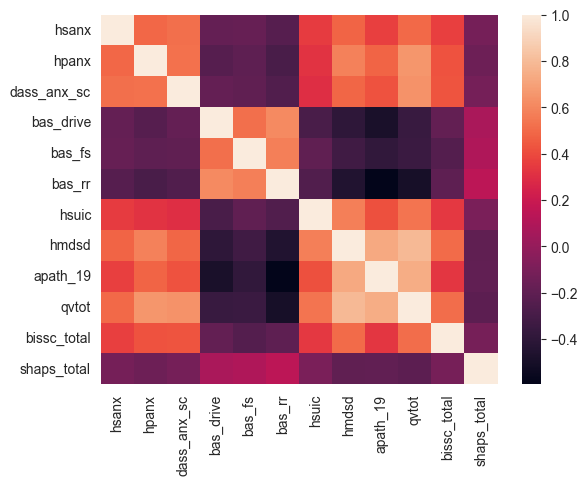

In [187]:
sns.heatmap(pdc_scores[pdc_columns].corr())  

## EP

In [22]:
def get_ep_data(df, participant_info):
    df['src_subject_id'] = df['src_subject_id'].astype("int64")
    return pd.merge(df, participant_info[['id', 'phenotype']], 
                    left_on='src_subject_id', 
                    right_on='id', 
                    how='right').drop('src_subject_id', axis=1)

In [23]:
ep_df = pd.read_excel(os.path.join(base_dir, 'EP', 'BehaviouralFiles.xlsx'), sheet_name=None)
ep_key = pd.read_csv(os.path.join(base_dir, 'EP', 'tmp', 'EPinfocomplete.csv'))
ep_key_part = pd.read_csv("sub_ids/ep_id.csv")
ep_key = ep_key[['imgkey', 'interview_age',	'sex', 'phenotype']]
ep_key['imgkey'] = ep_key['imgkey'].str.replace('_01_MR', '').str.lstrip().astype("int")
ep_key['phenotype'] = ep_key['phenotype'].str.replace('Patient', 'early_psychosis').str.lstrip()
ep_key = ep_key.rename(columns={'imgkey': 'id'})
ep_particpant_info = pd.merge(left=ep_key, right=ep_key_part, left_on='id', right_on='part',  how='right').drop('part', axis=1)
ep_particpant_info = ep_particpant_info[ep_particpant_info['phenotype'] != 'Control']

In [24]:
ep_df_keys = get_columns_from_dictionary(ep_questions)
edd_rs = get_ep_data(ep_df['predd01'][1:], ep_particpant_info)[['id', 'phenotype', 'edd_rs']]
panns_ep = get_ep_data(ep_df['panss01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['panss01']]
#yms_ep = get_ep_data(ep_df['ymrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['ymrs01']]
madrs_ep = get_ep_data(ep_df['madrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['madrs01']]
preda_ep = get_ep_data(ep_df['preda01'][1:][['src_subject_id', 'anx_rs'] + ep_df_keys['preda01']].dropna(), ep_particpant_info)[['id', 'phenotype', 'anx_rs']]
edd_rs = edd_rs.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
panns_ep = panns_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
#yms_ep = yms_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
madrs_ep = madrs_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
preda_ep = preda_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
ep_scores = merge_dataframes([
    panns_ep,
    madrs_ep, 
    edd_rs,
    preda_ep, 
    ep_particpant_info[['id', 'phenotype']]
    ])

In [25]:
ep_loadings_dict = {}
for phenotype in ep_questions.keys():
    ep_loadings_dict[phenotype] =  list({key for subdict in ep_questions[phenotype].values() for key in subdict if key not in ['anxiety34', 'idas_16', 'idas_56', 'idas_45', 'anxiety24', 'anxiety28', 'eddep04', 'eddep31', 'eddep54', 'eddep06', 'eddep36', 'eddep41','madrssad',  'eddep26', 'eddep17', 'eddep29', 'sleepamt', 'sexinter', 'neg_n5', 'gps_g11']})
ep_loadings_dict['anxiety'].extend(["anx_rs"])
ep_loadings_dict['depression'].extend(["edd_rs"])
ep_columns = ep_loadings_dict['anxiety'] + ep_loadings_dict['depression']

In [26]:
ep_data_fit = data_fit(ep_scores[ep_columns]) #convert_df_type(ep_scores[ep_columns]))
print(ep_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = ep_data_fit['kmo_all'].where(ep_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', ep_data_fit['kmo_model'])
print('\nbartlett pval', ep_data_fit['bartlett_pval'])
print('\nbart chi2',ep_data_fit['bartlett_chi2'])

       KMO Score
count  19.000000
mean    0.769216
std     0.113385
min     0.535423
25%     0.669867
50%     0.819338
75%     0.851619
max     0.893697

factors possibly not suitable: 
anx_rs   KMO Score    0.535423
neg_n4   KMO Score    0.566934
gps_g7   KMO Score    0.646372
neg_n2   KMO Score    0.693361
gps_g16  KMO Score    0.629991
edd_rs   KMO Score    0.632829
dtype: float64

model kmo 0.8014535744511584

bartlett pval 3.371121403142868e-79

bart chi2 783.8947880678105


In [27]:
obtain_correlation_values(ep_scores[ep_columns], 0.8)

Series([], dtype: float64)

In [29]:
ep_matrix = create_loading_design_matrix(ep_loadings_dict, ep_columns)

In [30]:
ep_scaled = scaled_data(ep_scores[ep_columns])
ep_model = cfa_model(ep_matrix, ep_scaled, len(ep_loadings_dict.keys()), len(ep_columns), [key for key in ep_loadings_dict.keys()])

In [31]:
det_corr = np.linalg.det(np.corrcoef(ep_scaled, rowvar=False))
print(f"Determinant of correlation matrix: {det_corr}")  

Determinant of correlation matrix: 0.0004890900650146968


In [33]:
fit = model_fit_parameters(ep_model, ep_scaled, cols=ep_columns)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression'})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,gps_g2,madrsten,gps_g4,anx_rs,madrsaps,neg_n4,gps_g3,madrscon,gps_g7,madrspes,madrslas,madrsfee,madrsapp,gps_g6,madrssui,madrsslp,neg_n2,gps_g16,edd_rs
depression,0.000000,0.000000,0.000000,0.000000,1.036361,0.846308,0.869274,1.073714,0.746273,1.139878,0.948084,1.040179,0.946465,1.169567,0.991682,0.848966,0.950461,0.830451,0.853803
anxiety,0.980092,0.971114,0.932454,0.619178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


'rmse 0.5261829505504781'

'mse 0.2980073066864062'

In [34]:
ep_data = pd.concat([ep_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(ep_model.fit_transform(ep_scaled)).rename(columns={0: "Anxiety", 1:"Depression"
                                                                                          })], axis=1)

In [35]:
ep_data[['Anxiety', 'Depression']].corr()

,Anxiety,Depression
Anxiety,1.000000,0.538405
Depression,0.538405,1.000000


In [36]:
ep_data

,id,phenotype,interview_age,sex,Anxiety,Depression
0,1006,early_psychosis,265,M,-0.498989,-0.618296
1,1009,early_psychosis,277,F,-0.485865,-0.679335
2,1012,early_psychosis,247,F,0.418768,-0.679335
3,1013,early_psychosis,358,F,-0.340277,-0.760720
4,1015,early_psychosis,237,M,-0.618110,-0.699681
...,...,...,...,...,...,...
106,4071,early_psychosis,244,F,1.607206,0.099491
107,4074,early_psychosis,272,F,-0.005677,0.671184
108,4075,early_psychosis,235,M,0.502273,1.493699
109,4088,early_psychosis,291,F,-0.421802,0.443704


<Axes: >

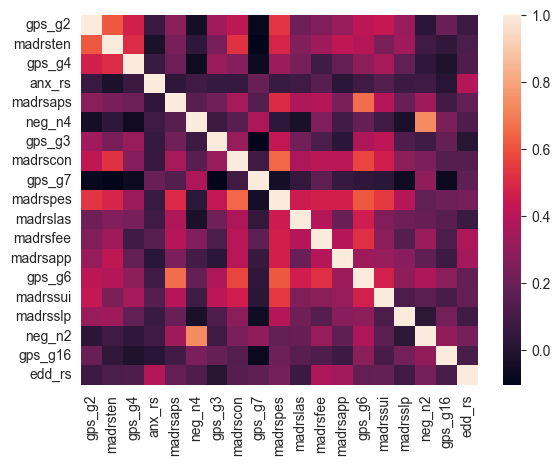

In [37]:
sns.heatmap(ep_scores[ep_columns].corr())  

## BANDA

In [38]:

banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [39]:
banda_df_keys = get_columns_from_dictionary(banda_questions)

In [40]:
state_cols = [col for col in banda_df["stai01"].columns if "Right now" in str(banda_df["stai01"].loc[0, col])]
trait_cols = [col for col in banda_df["stai01"].columns if "Generally" in str(banda_df["stai01"].loc[0, col])]

In [41]:
stai01 = banda_df["stai01"][banda_df["stai01"]['visit'] == 'T1']
stai01 = stai01.drop(stai01[stai01['src_subject_id'].duplicated()].index)
stai01 = pd.merge(stai01.drop(["collection_id", "stai01_id", "dataset_id", "subjectkey"], axis=1), band_particpant_info, left_on='src_subject_id', right_on='id')
stai01 = stai01.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)

In [42]:
transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = impute_group_median(group[state_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_state = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_state = stai01_state.rename(columns={"src_subject_id": "id", 0: "state_val"}).sort_values(by='id')

transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = impute_group_median(group[trait_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_trait = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_trait = stai01_trait.rename(columns={"src_subject_id": "id", 0: "trait_val"}).sort_values(by='id')

Anxiety
Control
Depression
Anxiety
Control
Depression


In [43]:
mfq_banda = questionnaire_transform_merge(banda_df["mfq01"], band_particpant_info, 'mfq01_id', "mfq_score", banda_df["mfq01"].columns[8: 41]).drop("phenotype", axis=1)
shaps_banda = questionnaire_transform_merge(banda_df["shaps01"], band_particpant_info, 'shaps01_id', "shaps_score", banda_df["shaps01"].columns[8: 22]).drop("phenotype", axis=1)
cbcl_banda = process_questionnaire(banda_df["cbcl01"], band_particpant_info, 'cbcl01_id')[['id', 'phenotype']+ banda_questions['depression']['cbcl01']].drop("phenotype", axis=1)
rcads_banda = score_rcads(banda_df['rcads01']).drop(["internalising", "anxiety"], axis=1)

In [44]:
merged_df = merge_dataframes([
    rcads_banda,
    stai01_state.drop("phenotype", axis=1),
    stai01_trait.drop("phenotype", axis=1),
    shaps_banda,
    mfq_banda,
    cbcl_banda])
banda_df_scored = pd.merge(band_particpant_info, merged_df, how='outer')
banda_df_scored = banda_df_scored.replace("999", np.nan)
banda_df_scored[banda_df_scored.columns[4:]] = banda_df_scored[banda_df_scored.columns[4:]].applymap(lambda x: pd.to_numeric(x, errors='coerce') if pd.notna(x) else x)


In [45]:
banda_df_scored

,id,phenotype,sex,interview_age,maj_depression,panic_disorder,seperation_anxiety,general_anxiety,ocd,social_phobia,state_val,trait_val,shaps_score,mfq_score,cbcl35,cbcl52,cbcl54,cbcl76,cbcl77,cbcl91
0,BANDA001,Control,F,184,3.0,1.0,2.0,2.0,0.0,19.0,42.0,47.0,38.0,37.0,0.0,0.0,NaN,0.0,0.0,0.0
1,BANDA002,Control,F,169,2.0,4.0,0.0,1.0,1.0,8.0,46.0,41.0,38.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BANDA003,Control,M,177,1.0,0.0,0.0,0.0,0.0,3.0,49.0,44.0,36.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BANDA004,Control,M,188,7.0,2.0,0.0,1.0,3.0,11.0,47.0,45.0,32.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BANDA005,Control,M,191,3.0,0.0,0.0,1.0,0.0,0.0,42.0,33.0,36.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,5.0,6.0,7.0,5.0,1.0,11.0,54.0,52.0,55.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0
199,BANDA211,Depression,F,196,16.0,9.0,3.0,9.0,2.0,15.0,56.0,60.0,52.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0
200,BANDA212,Depression,F,186,22.0,11.0,10.0,14.0,9.0,23.0,61.0,67.0,52.0,80.0,1.0,0.0,2.0,0.0,2.0,1.0
201,BANDA213,Depression,F,184,23.0,15.0,14.0,8.0,5.0,27.0,56.0,65.0,51.0,77.0,1.0,2.0,0.0,0.0,0.0,0.0


In [46]:
grouping = banda_df_scored.groupby("phenotype")
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].median(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']]).sort_values("id")

In [47]:
banda_loadings = {
    "anxiety": ['panic_disorder', 'seperation_anxiety', 'general_anxiety', 'ocd', 'social_phobia', 'state_val', 'trait_val'],
    "depression": ['shaps_score', 'mfq_score', 'cbcl35', 'cbcl52', 'cbcl54','cbcl77', 'cbcl91']
}
banda_columns = banda_loadings['anxiety'] + banda_loadings['depression']

<Axes: >

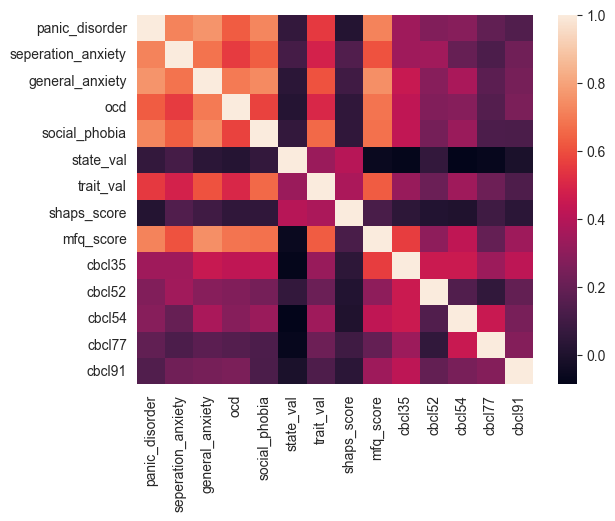

In [48]:
sns.heatmap(banda_df_scored[banda_columns].corr())  

In [49]:
banda_data_fit = data_fit(convert_df_type(banda_df_scored[banda_columns]))
print(banda_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = banda_data_fit['kmo_all'].where(banda_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', banda_data_fit['kmo_model'])
print('\nbartlett pval', banda_data_fit['bartlett_pval'])
print('\nbart chi2',banda_data_fit['bartlett_chi2'])

       KMO Score
count  14.000000
mean    0.794365
std     0.147384
min     0.459917
25%     0.779174
50%     0.839657
75%     0.884966
max     0.948484

factors possibly not suitable: 
state_val    KMO Score    0.459917
shaps_score  KMO Score    0.541905
cbcl77       KMO Score    0.639178
dtype: float64

model kmo 0.8531477896025014

bartlett pval 4.731424710068967e-249

bart chi2 1477.0837026873485


In [50]:
obtain_correlation_values(banda_df_scored[banda_columns], 0.8)

Series([], dtype: float64)

In [53]:
banda_matrix = create_loading_design_matrix(banda_loadings, banda_columns)

In [54]:
groupsby = banda_df_scored.groupby('phenotype')
control = groupsby.get_group("Control")
control = scaled_data(control[banda_columns])
axniety = groupsby.get_group("Anxiety")
axniety = scaled_data(axniety[banda_columns])
depression = groupsby.get_group("Depression")
depression = scaled_data(depression[banda_columns])

In [55]:
banda_scaled = pd.DataFrame(np.vstack([control, axniety, depression]))
banda_model = cfa_model(banda_matrix, banda_scaled, len(banda_loadings.keys()), len(banda_columns), [key for key in banda_loadings.keys()])

In [40]:
det_corr = np.linalg.det(banda_scaled.corr())
print(f"Determinant of correlation matrix: {det_corr}")   

Determinant of correlation matrix: 0.017129712565938985


In [56]:
fit = model_fit_parameters(banda_model, banda_scaled, cols=banda_columns)
load_df = fit['loadings'].rename(index={0:"Depression", 1: "Anxiety"})
display(load_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,panic_disorder,seperation_anxiety,general_anxiety,ocd,social_phobia,state_val,trait_val,shaps_score,mfq_score,cbcl35,cbcl52,cbcl54,cbcl77,cbcl91
Depression,0.97831,0.922293,1.031944,0.898719,1.031124,0.645573,0.891593,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Anxiety,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.774278,0.918718,0.99843,0.866347,0.924618,0.897474,0.799789


'rmse 0.4255745323491963'

'mse 0.1858876822417015'

<Axes: >

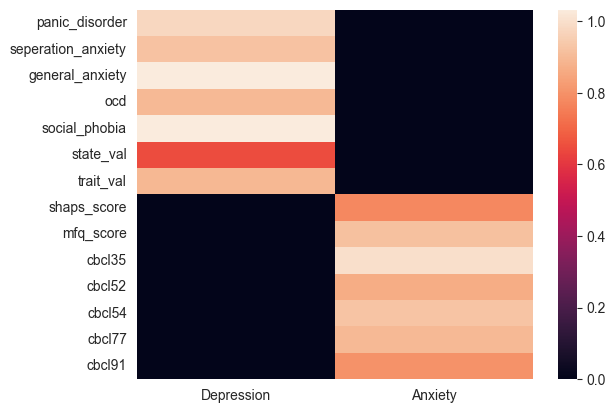

In [57]:
sns.heatmap(load_df.T)

In [58]:
banda_data = pd.concat([banda_df_scored[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(banda_model.fit_transform(banda_df_scored[banda_columns].values)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Psychosis"})], axis=1)

In [59]:
banda_data[["Anxiety", "Depression"]].corr()

,Anxiety,Depression
Anxiety,1.000000,0.787608
Depression,0.787608,1.000000


<Axes: >

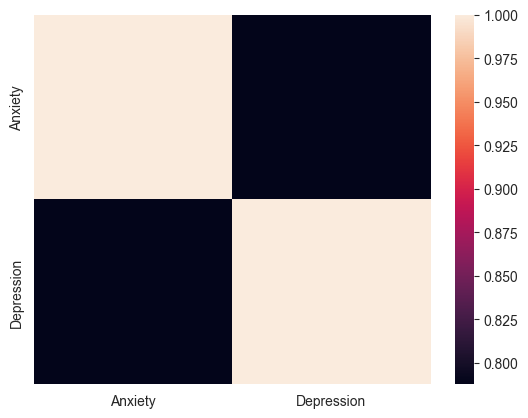

In [60]:
sns.heatmap(banda_data[["Anxiety", "Depression"]].corr())

In [182]:
from factor_analysis import check_variables

In [132]:
combined_df = pd.concat([banda_data, ep_data, pdc_data])

In [100]:
combined_df

,id,phenotype,interview_age,sex,Anxiety,Depression
0,BANDA001,Control,184,F,-0.087900,-2.056247
1,BANDA002,Control,169,F,-1.813301,-1.779342
2,BANDA003,Control,177,M,-2.705669,-2.587228
3,BANDA004,Control,188,M,-1.176939,-1.987759
4,BANDA005,Control,191,M,-3.910133,-2.587228
...,...,...,...,...,...,...
211,h_0060,Control,392,F,-0.606481,-0.289448
212,h_0062,Control,293,M,-0.374294,-1.200026
213,h_0063,Control,401,M,-1.616430,-0.917395
214,h_0064,Control,289,F,-0.075685,1.582145


<Axes: >

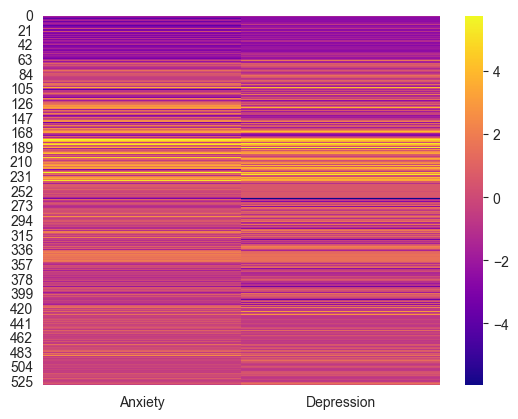

In [327]:
combined_df = pd.concat([banda_data, ep_data, pdc_data])
plotting_banda_data = combined_df.groupby("phenotype")
plotting_banda_data = pd.concat([plotting_banda_data.get_group("Control"), 
                                 plotting_banda_data.get_group("Anxiety"), 
                                 plotting_banda_data.get_group("Depression"), 
                                 plotting_banda_data.get_group("MDD"),
                                 plotting_banda_data.get_group("early_psychosis")]).reset_index(drop=True)
sns.heatmap(plotting_banda_data[['Anxiety', 'Depression']], cmap='plasma')

In [328]:
combined_df.groupby("phenotype")[["Anxiety", "Depression"]].median()

,Anxiety,Depression
phenotype,,
Anxiety,0.454324,-0.320506
Control,-1.588439,-1.675134
Depression,1.380061,2.385014
MDD,-0.063404,0.245889
early_psychosis,-0.195042,-0.224376


In [329]:
check_variables(combined_df, ['Anxiety', 'Depression'])

ANOVA for Anxiety: F=46.52, p=0.0000

        Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
   Anxiety         Control  -1.8538    0.0 -2.4203 -1.2872   True
   Anxiety      Depression   1.0178 0.0001  0.3873  1.6484   True
   Anxiety             MDD  -0.4667 0.0853 -0.9713  0.0379  False
   Anxiety early_psychosis  -0.4788 0.1221 -1.0293  0.0717  False
   Control      Depression   2.8716    0.0   2.271  3.4722   True
   Control             MDD   1.3871    0.0  0.9205  1.8537   True
   Control early_psychosis   1.3749    0.0   0.859  1.8909   True
Depression             MDD  -1.4846    0.0 -2.0271  -0.942   True
Depression early_psychosis  -1.4967    0.0 -2.0822 -0.9112   True
       MDD early_psychosis  -0.0121    1.0 -0.4591  0.4349  False
-----------------------------------------------------------------
ANOVA for Depression: F=55.68, p=0.00

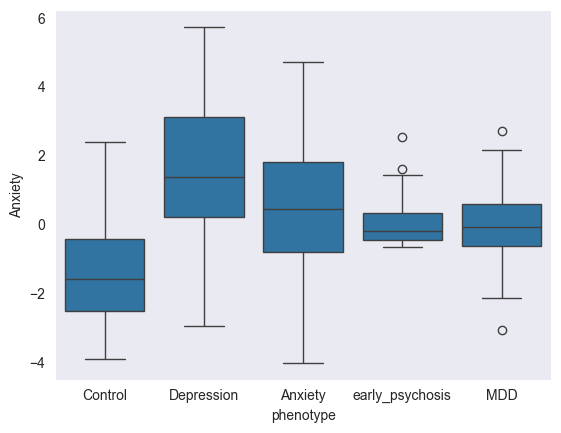

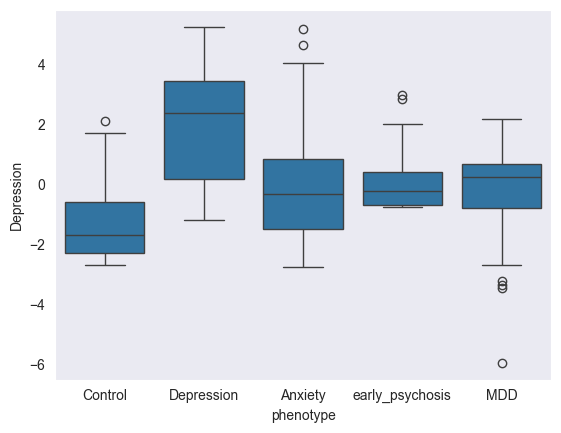

In [330]:
for val in ['Anxiety', 'Depression']:
    plot = sns.boxplot(data=combined_df, x='phenotype', y=val,)
    plt.show()